# `get_offline_features()` from MLRun FeatureStore

This MLRun Function has the following `params`:

- `feature_vector: str`,                 feature vector uri.

- `entity_rows: DataItem` = None,        URI of the data entity rows to join with.

- `entity_timestamp_column: str = None`, timestamp column name in the entity rows dataframe.

- `target: Union[str, Dict] = None`,     where to write the results to.

- `run_config: Union[str, Dict] = None`, function and/or run configuration see :py:class:`~mlrun.feature_store.RunConfig`.

- `drop_columns: List[str] = None`,      list of columns to drop from the final result. 

- `start_time: str = None`,              datetime, low limit of time needed to be filtered. Optional. `entity_timestamp_column` must be passed when using time filtering.

- `end_time: str = None`,                datetime, high limit of time needed to be filtered. Optional. `entity_timestamp_column` must be passed when using time filtering.

- `with_indexes: bool = False`,          return vector with index columns (default False).

- `update_stats: bool = False`,          update features statistics from the requested feature sets on the vector. Default is False.

In [1]:
import mlrun
import mlrun.feature_store as fstore
from mlrun.datastore.targets import CSVTarget
from mlrun.datastore.sources import CSVSource
from mlrun.run import get_dataitem
from mlrun.feature_store.steps import *
from mlrun.features import MinMaxValidator
import pandas as pd
import datetime
import os

In [2]:
ABS_PATH = 'v3io://users/{}/get_offline_features/'.format(os.environ['V3IO_USERNAME'])
# Initialize the MLRun project object
project = mlrun.get_or_create_project('get-offline-features', context="./", user_project=True)

> 2022-01-31 14:41:48,288 [info] loaded project get-offline-features from MLRun DB


## Generating the Same FeatureSets and FeatureVecotrs Based on the Stocks Example

### Create Sample Data For Demo

In [3]:
quotes = pd.DataFrame(
    {
        "time": [
            pd.Timestamp("2016-05-25 13:30:00.023"),
            pd.Timestamp("2016-05-25 13:30:00.023"),
            pd.Timestamp("2016-05-25 13:30:00.030"),
            pd.Timestamp("2016-05-25 13:30:00.041"),
            pd.Timestamp("2016-05-25 13:30:00.048"),
            pd.Timestamp("2016-05-25 13:30:00.049"),
            pd.Timestamp("2016-05-25 13:30:00.072"),
            pd.Timestamp("2016-05-25 13:30:00.075")
        ],
        "ticker": [
               "GOOG",
               "MSFT",
               "MSFT",
               "MSFT",
               "GOOG",
               "AAPL",
               "GOOG",
               "MSFT"
           ],
           "bid": [720.50, 51.95, 51.97, 51.99, 720.50, 97.99, 720.50, 52.01],
           "ask": [720.93, 51.96, 51.98, 52.00, 720.93, 98.01, 720.88, 52.03]
    }
)

trades = pd.DataFrame(
       {
           "time": [
               pd.Timestamp("2016-05-25 13:30:00.023"),
               pd.Timestamp("2016-05-25 13:30:00.038"),
               pd.Timestamp("2016-05-25 13:30:00.048"),
               pd.Timestamp("2016-05-25 13:30:00.048"),
               pd.Timestamp("2016-05-25 13:30:00.048")
           ],
           "ticker": ["MSFT", "MSFT", "GOOG", "GOOG", "AAPL"],
           "price": [51.95, 51.95, 720.77, 720.92, 98.0],
           "quantity": [75, 155, 100, 100, 100]
       }
)

stocks = pd.DataFrame(
       {
           "ticker": ["MSFT", "GOOG", "AAPL"],
           "name": ["Microsoft Corporation", "Alphabet Inc", "Apple Inc"],
           "exchange": ["NASDAQ", "NASDAQ", "NASDAQ"]
       }
)

In [4]:
def move_date(df, col):
    max_date = df[col].max()
    now_date = datetime.datetime.now()
    delta = now_date - max_date 
    df[col] = df[col] + delta 
    return df

quotes = move_date(quotes, "time")
trades = move_date(trades, "time")
trades.to_csv('trades.csv', index=False)
data_uri = os.path.join(ABS_PATH, 'trades.csv')

In [5]:
quotes

,time,ticker,bid,ask
0,2022-01-31 14:41:48.260566,GOOG,720.50,720.93
1,2022-01-31 14:41:48.260566,MSFT,51.95,51.96
2,2022-01-31 14:41:48.267566,MSFT,51.97,51.98
3,2022-01-31 14:41:48.278566,MSFT,51.99,52.00
4,2022-01-31 14:41:48.285566,GOOG,720.50,720.93
5,2022-01-31 14:41:48.286566,AAPL,97.99,98.01
6,2022-01-31 14:41:48.309566,GOOG,720.50,720.88
7,2022-01-31 14:41:48.312566,MSFT,52.01,52.03


In [6]:
trades

,time,ticker,price,quantity
0,2022-01-31 14:41:48.288476,MSFT,51.95,75
1,2022-01-31 14:41:48.303476,MSFT,51.95,155
2,2022-01-31 14:41:48.313476,GOOG,720.77,100
3,2022-01-31 14:41:48.313476,GOOG,720.92,100
4,2022-01-31 14:41:48.313476,AAPL,98.00,100


In [7]:
stocks

,ticker,name,exchange
0,MSFT,Microsoft Corporation,NASDAQ
1,GOOG,Alphabet Inc,NASDAQ
2,AAPL,Apple Inc,NASDAQ


### Build & Ingest Simple Feature Set (stocks)

In [8]:
# add feature set without time column (stock ticker metadata) 
stocks_set = fstore.FeatureSet("stocks", entities=[fstore.Entity("ticker")])
fstore.ingest(stocks_set, stocks, infer_options=fstore.InferOptions.default())

,name,exchange
ticker,,
MSFT,Microsoft Corporation,NASDAQ
GOOG,Alphabet Inc,NASDAQ
AAPL,Apple Inc,NASDAQ


### Build Advanced feature set - with feature engineering pipeline

In [9]:
quotes_set = fstore.FeatureSet("stock-quotes", entities=[fstore.Entity("ticker")])

In [10]:
class MyMap(MapClass):
    def __init__(self, multiplier=1, **kwargs):
        super().__init__(**kwargs)
        self._multiplier = multiplier

    def do(self, event):
        event["multi"] = event["bid"] * self._multiplier
        return event

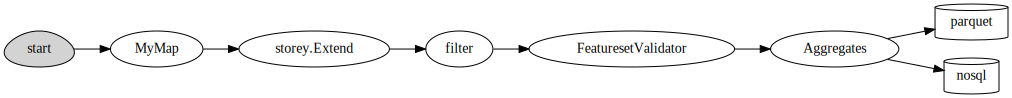

In [11]:
quotes_set.graph.to("MyMap", multiplier=3)\
                .to("storey.Extend", _fn="({'extra': event['bid'] * 77})")\
                .to("storey.Filter", "filter", _fn="(event['bid'] > 51.92)")\
                .to(FeaturesetValidator())

quotes_set.add_aggregation("ask", ["sum", "max"], "1h", "10m", name="asks1")
quotes_set.add_aggregation("ask", ["sum", "max"], "5h", "10m", name="asks5")
quotes_set.add_aggregation("bid", ["min", "max"], "1h", "10m", name="bids")

# add feature validation policy
quotes_set["bid"] = fstore.Feature(validator=MinMaxValidator(min=52, severity="info"))

# add default target definitions and plot
quotes_set.set_targets()
quotes_set.plot(rankdir="LR", with_targets=True)

### Ingest Data Into Offline And Online Stores

In [12]:
# save ingest data and print the FeatureSet spec
fstore.ingest(quotes_set, quotes)

info! bid value is smaller than min, key=['MSFT'] time=2022-01-31 14:41:51.377248+00:00 args={'min': 52, 'value': 51.95}
info! bid value is smaller than min, key=['MSFT'] time=2022-01-31 14:41:51.377927+00:00 args={'min': 52, 'value': 51.97}
info! bid value is smaller than min, key=['MSFT'] time=2022-01-31 14:41:51.378103+00:00 args={'min': 52, 'value': 51.99}
info! bid value is smaller than min, key=['MSFT'] time=2022-01-31 14:41:51.578640+00:00 args={'min': 52, 'value': 51.95}
info! bid value is smaller than min, key=['MSFT'] time=2022-01-31 14:41:51.581692+00:00 args={'min': 52, 'value': 51.97}
info! bid value is smaller than min, key=['MSFT'] time=2022-01-31 14:41:51.584351+00:00 args={'min': 52, 'value': 51.99}


,asks1_max_1h,asks1_sum_1h,asks5_max_5h,asks5_sum_5h,bids_max_1h,bids_min_1h,time,bid,ask,multi,extra
ticker,,,,,,,,,,,
GOOG,720.93,720.93,720.93,720.93,720.50,720.50,2022-01-31 14:41:48.260566,720.50,720.93,2161.50,55478.50
MSFT,51.96,51.96,51.96,51.96,51.95,51.95,2022-01-31 14:41:48.260566,51.95,51.96,155.85,4000.15
MSFT,51.98,103.94,51.98,103.94,51.97,51.95,2022-01-31 14:41:48.267566,51.97,51.98,155.91,4001.69
MSFT,52.00,155.94,52.00,155.94,51.99,51.95,2022-01-31 14:41:48.278566,51.99,52.00,155.97,4003.23
GOOG,720.93,1441.86,720.93,1441.86,720.50,720.50,2022-01-31 14:41:48.285566,720.50,720.93,2161.50,55478.50
AAPL,98.01,98.01,98.01,98.01,97.99,97.99,2022-01-31 14:41:48.286566,97.99,98.01,293.97,7545.23
GOOG,720.93,2162.74,720.93,2162.74,720.50,720.50,2022-01-31 14:41:48.309566,720.50,720.88,2161.50,55478.50
MSFT,52.03,207.97,52.03,207.97,52.01,51.95,2022-01-31 14:41:48.312566,52.01,52.03,156.03,4004.77


### Get an Offline Feature Vector

In [13]:
features = [
    "stock-quotes.multi",
    "stock-quotes.asks5_sum_5h as total_ask",
    "stock-quotes.bids_min_1h",
    "stock-quotes.bids_max_1h",
    "stocks.*",
]

vector = fstore.FeatureVector("stocks-vec", features)
vector.save()

In [14]:
target_dict = CSVTarget('mycsv',path=os.path.join(ABS_PATH, 'my_csv.csv')).to_dict()

### Using `get_offline_features()` 

In [15]:
get_offline_features_fn = mlrun.import_function('hub://get_offline_features:development')

In [16]:
gof_run = get_offline_features_fn.run(
    handler='get_offline_features',
    inputs= {'entity_rows': data_uri},
    params={'feature_vector': vector.uri,
           'target': target_dict,
            'entity_timestamp_column': "time",
           },
    local=True
)

> 2022-01-31 14:41:52,066 [info] starting run get-offline-features-get_offline_features uid=956663b9a9ba448c9ea65e8e9245718e DB=http://mlrun-api:8080
> 2022-01-31 14:41:52,214 [info] Creating DataFrame from entity_rows = v3io://users/yonatan/get_offline_features/trades.csv
> 2022-01-31 14:41:52,292 [info] Preparing 'mycsv' target
> 2022-01-31 14:41:52,294 [info] getting offline features from the FeatureVector store://feature-vectors/get-offline-features-yonatan/stocks-vec
> 2022-01-31 14:41:52,708 [info] wrote target: {'name': 'mycsv', 'kind': 'csv', 'path': 'v3io://users/yonatan/get_offline_features/my_csv.csv', 'status': 'ready', 'updated': '2022-01-31T14:41:52.708534+00:00'}


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
get-offline-features-yonatan,...9245718e,0,Jan 31 14:41:52,completed,get-offline-features-get_offline_features,v3io_user=yonatankind=owner=yonatanhost=jupyter-yoni-647b99c95d-w4jlc,entity_rows,"feature_vector=store://feature-vectors/get-offline-features-yonatan/stocks-vectarget={'name': 'mycsv', 'kind': 'csv', 'path': 'v3io://users/yonatan/get_offline_features/my_csv.csv', 'partitioned': False}entity_timestamp_column=time",target=v3io://users/yonatan/get_offline_features/my_csv.csvfeature_vector=store://feature-vectors/get-offline-features-yonatan/stocks-vec,


> 2022-01-31 14:41:52,896 [info] run executed, status=completed


In [17]:
gof_run.outputs['feature_vector']

'store://feature-vectors/get-offline-features-yonatan/stocks-vec'

In [18]:
mlrun.get_dataitem(gof_run.outputs['feature_vector']).as_df()

,Unnamed: 0,price,quantity,multi,total_ask,bids_min_1h,bids_max_1h,name,exchange
0,0,51.95,75,155.85,51.96,51.95,51.95,Microsoft Corporation,NASDAQ
1,1,51.95,75,155.91,103.94,51.95,51.97,Microsoft Corporation,NASDAQ
2,2,51.95,75,155.97,155.94,51.95,51.99,Microsoft Corporation,NASDAQ
3,3,51.95,75,156.03,207.97,51.95,52.01,Microsoft Corporation,NASDAQ
4,4,51.95,155,155.85,51.96,51.95,51.95,Microsoft Corporation,NASDAQ
5,5,51.95,155,155.91,103.94,51.95,51.97,Microsoft Corporation,NASDAQ
6,6,51.95,155,155.97,155.94,51.95,51.99,Microsoft Corporation,NASDAQ
7,7,51.95,155,156.03,207.97,51.95,52.01,Microsoft Corporation,NASDAQ
8,8,720.77,100,2161.50,720.93,720.50,720.50,Alphabet Inc,NASDAQ
9,9,720.77,100,2161.50,1441.86,720.50,720.50,Alphabet Inc,NASDAQ
